In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy

In [2]:
folder = 'data/'
state = 'fl_statewide_2020_04_01.csv'
state2 = 'ca_long_beach_2020_04_01.csv'

# Preprocessing whole dataset (do not execute if working on full data)

In [ ]:
df_full = pd.read_csv(folder + state)
print(df_full.columns)

Reducing the amount of data for experimentation

In [ ]:
cut_file_path = folder + state.split('.')[0] + "_cut.csv"
total_size = df_full.shape[0]
df = df_full.sample(n=int(total_size/100))
print("Full dataset of size {} was reduced to subset of {} elements.".format(total_size, df.shape[0]))
df.to_csv(cut_file_path, index = False)

# Load the data (currently loading all data)

In [3]:
df =  pd.read_csv(folder + state)
print("Dataset is composed of {} stops. Columns are: \n".format(df.shape[0]))
for col in df.columns:
    if df.dtypes[col] != np.float64:
        val = df[col].unique()
        if len(val) > 20:
            print('{} \t\t: too much different values'.format(col))
        else:
            print('{} \t\t: values are: {}'.format(col if len(col)>15 else col + "\t\t", val))
df = df.rename(columns={'officer_years_of_service': 'officer_yos'})

Dataset is composed of 7297538 stops. Columns are: 

raw_row_number 		: too much different values
date 		: too much different values
time 		: too much different values
location 		: too much different values
county_name 		: too much different values
subject_race		 		: values are: [nan 'white' 'black' 'hispanic' 'asian/pacific islander' 'other' 'unknown']
subject_sex		 		: values are: ['female' 'male' nan]
officer_id_hash 		: too much different values
officer_race		 		: values are: [nan 'black' 'white' 'hispanic' 'unknown' 'asian/pacific islander' 'other']
officer_sex		 		: values are: [nan 'male' 'female']
department_name		 		: values are: ['FLORIDA HIGHWAY PATROL' 'FLORIDA HIGHWAY PATROL - TROOP K'
 'FLORIDA HIGHWAY PATROL  MOTORS SQ' 'FLORIDA DEPARTMENT OF AGRICULTURE'
 nan]
unit 		: too much different values
type		 		: values are: ['vehicular']
violation 		: too much different values
arrest_made		 		: values are: [nan False True]
citation_issued		 		: values are: [True False nan]
war

# Preprocess to compare search rates

Calculate search rates for each officer race and each subject race across each county

# General functions

In [4]:
minority_race = ['black', 'hispanic']

def remove_general_unused_columns(data):
    columns_unused = ['officer_id_hash', 'vehicle_registration_state', 'type']
    columns_reasons = ['reason_for_stop', 'reason_for_search', 'notes', 'violation', 'search_basis']
    columns_raw = ['raw_EnforcementAction', 'raw_SearchType', 'raw_Ethnicity', 'raw_row_number_new', 'raw_Race', 'raw_row_number_old', 'raw_row_number']
    columns_geography = ['location', 'date','time', 'department_name', 'unit']
    return data.drop(columns=columns_unused + columns_reasons + columns_raw + columns_geography)

def print_search_rate(data):
    number_stops = data['search_conducted'].shape[0]
    number_search_conducted = data[data['search_conducted'] == True].shape[0]
    print('Data contains {} stops and {} of them ({}%) resulted in searches.'.format(number_stops, number_search_conducted, 100 * float(number_search_conducted)/number_stops))

def preprocess_for_grouping(data):
    data['search_rate'] = data['search_conducted']
    data = data.astype({'search_rate': float})
    data['count'] = 1 # to count occurences
    return data

def separate_data(data, categories):
    df = {}
    for exp in categories:
        df[exp] = data.loc[exp]
    return df


In [5]:
from scipy.stats import linregress

def plot_race(data, min_race, categories, threshold):

    fig, ax_arr = plt.subplots(1, 3) # 2 graphs
    fig.set_size_inches(14,5) # fig size
    fig.suptitle(min_race.title() + " people search rates among officers".format(min_race))

    for i, off_feat in enumerate(categories):

        data_ = data[off_feat]
        df_white_sub, df_minority = data_.loc['white'], data_.loc[min_race] #separate data
        df_white_sub.reset_index(inplace=True), df_minority.reset_index(inplace=True) #reset index
        df_merged = pd.merge(df_white_sub, df_minority, on='county_name', suffixes=['_white', '_minority']) # merge both

        # remove where there are too little datapoints
        cond_minority = df_merged['count_minority'] >= threshold

        x = df_merged['search_rate_white'][cond_minority]*100
        y = df_merged['search_rate_minority'][cond_minority]*100
        s = df_merged['count_minority'][cond_minority]/100

        ax_arr[i].scatter(x, y, s=s, c="None", edgecolors='black', linewidth=0.4)
        ax_arr[i].set_xlabel("White search rate (%)")
        ax_arr[i].set_ylabel(min_race.title() + " search rate (%)")


        #plot regression
        a, b, r, p_value, std_err = linregress(x, y)
        sns.regplot(x=x, y=y, ax=ax_arr[i], label='{:.1f}*x + {:.1f}, r={:.2f}'.format(a,b,r), scatter=False).legend(loc="best")

        ax_arr[i].set_title(off_feat.title() +' officers')

        # draw dotted line
        max_ = df_merged['search_rate_minority'][cond_minority].max()
        line = np.arange(0, max_ * 100, max_)
        ax_arr[i].plot(line, line, c='black', linestyle=(0,(5,5)), linewidth=1)


def plot_search_rates(data, categories, threshold=500):
    for race in minority_race:
        plot_race(data, race, categories, threshold)

# Race of officer

In [6]:
officer_race = ['white', 'black', 'hispanic']

In [7]:
df_race = copy(df)

# remove unused columns
df_race = remove_general_unused_columns(df_race)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_race', 'search_conducted']
df_race.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_race.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_race)

# preprocess for grouping
df_race = preprocess_for_grouping(df_race)

# add specific column for this type of analyzis
df_race_all = df_race.groupby(['officer_race','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4191965 datapoints
Data contains 4191965 stops and 25708 of them (0.6132684791022825%) resulted in searches.


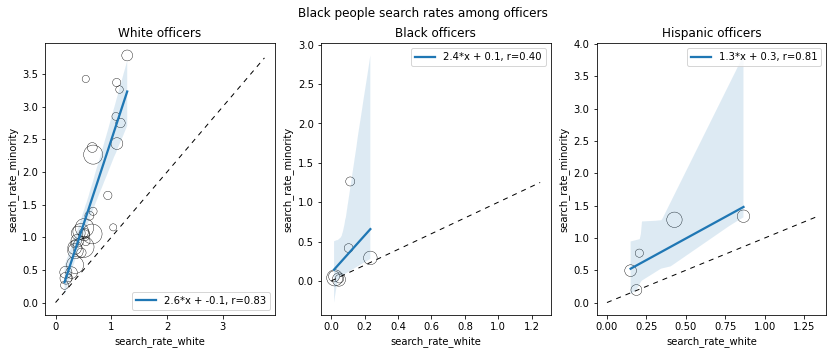

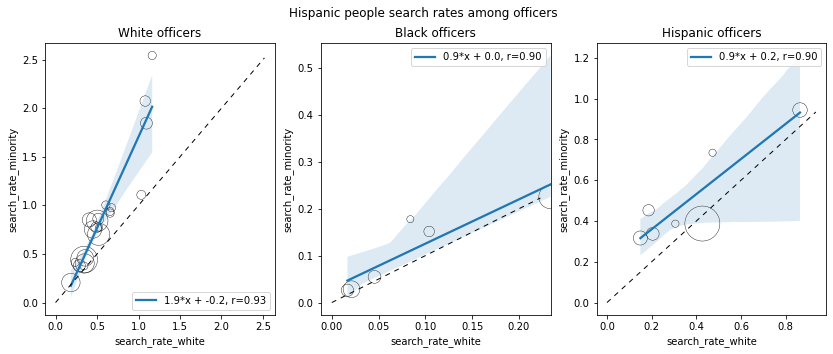

In [8]:
# separate data
df_race_sep = separate_data(df_race_all, officer_race)
df_race_sep[officer_race[0]].head(2)

# plot it 
plot_search_rates(df_race_sep, officer_race, 5000)

# Experience of officer

In [9]:
officer_experience_level = ['young', 'experienced', 'old']
thresholds_experience = [2, 9]

Preprocess the data to have what is needed

In [10]:
df_yos = copy(df)

# remove unused columns
df_yos = remove_general_unused_columns(df_yos)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_yos', 'search_conducted']
df_yos.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_yos.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_yos)

# preprocess for grouping
df_yos = preprocess_for_grouping(df_yos)

# add specific column for this type of analyzis
df_yos['age_category'] = df_yos['officer_yos'].apply(lambda x : officer_experience_level[0] if x < thresholds_experience[0] else (officer_experience_level[1] if x < thresholds_experience[1] else officer_experience_level[2]))
df_yos_all = df_yos.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4995855 datapoints
Data contains 4995855 stops and 28712 of them (0.5747164399287009%) resulted in searches.


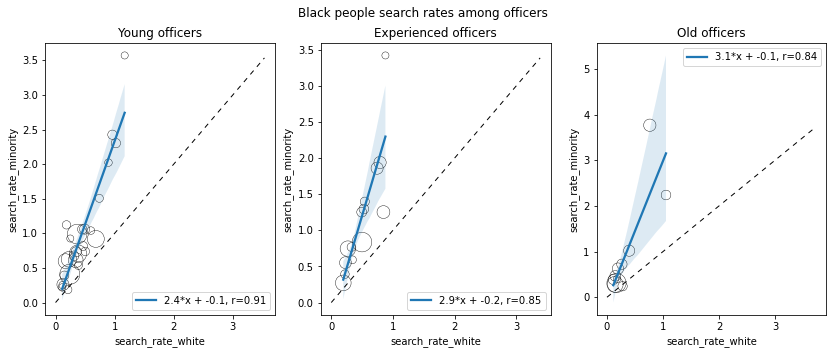

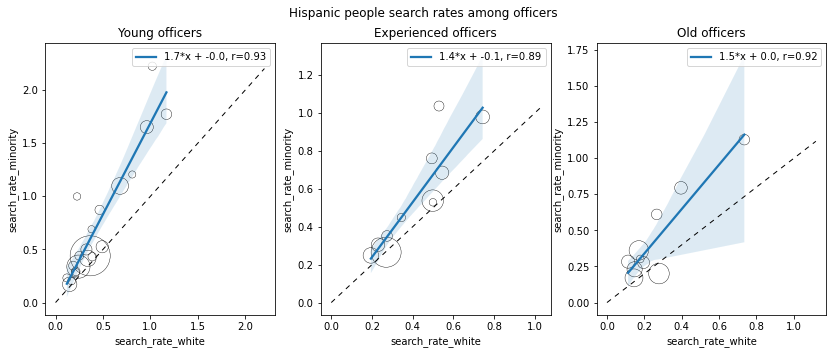

In [11]:
# separate data
df_yos_sep = separate_data(df_yos_all, officer_experience_level)
df_yos_sep[officer_experience_level[0]].head(2)

# plot it 
plot_search_rates(df_yos_sep, officer_experience_level, 5000)

# Age of the officer

In [12]:
officer_age_level = ['young', 'experienced', 'old']
thresholds_age = [30, 50]

In [13]:
df_age = copy(df)

# remove unused columns
df_age = remove_general_unused_columns(df_age)

# make sure that required data are present (drop if nan values in those columns)
important_features = ['subject_race', 'officer_age', 'search_conducted']
df_age.dropna(inplace=True, subset=important_features)
print('Cleaned subset is composed of {} datapoints'.format(df_yos.shape[0]))

# overview of all the data / global search rate
print_search_rate(df_age)

# preprocess for grouping
df_age = preprocess_for_grouping(df_age)

# add specific column for this type of analyzis
df_age['age_category'] = df_age['officer_age'].apply(lambda x : officer_age_level[0] if x < thresholds_age[0] else (officer_age_level[1] if x < thresholds_age[1] else officer_age_level[2]))
df_age_all = df_age.groupby(['age_category','subject_race','county_name']).agg({'search_rate': 'mean', 'count':'count'})

Cleaned subset is composed of 4995855 datapoints
Data contains 4423122 stops and 26619 of them (0.6018147362880789%) resulted in searches.


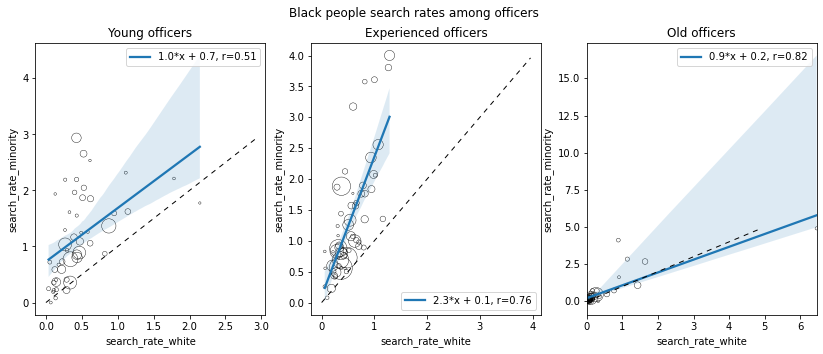

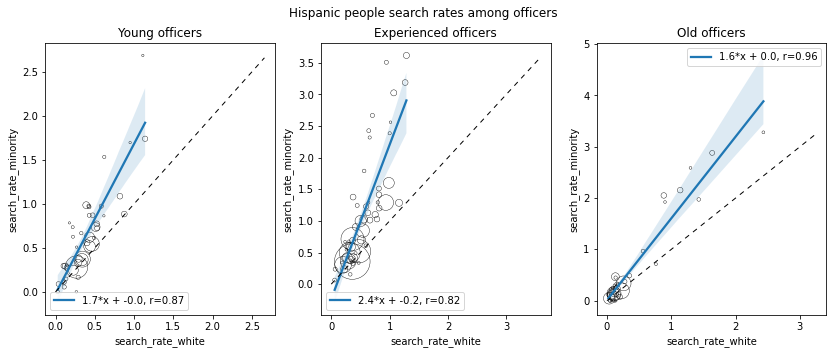

In [14]:
# separate data
df_age_sep = separate_data(df_age_all, officer_age_level)
df_age_sep[officer_age_level[0]].head(2)

# plot it 
plot_search_rates(df_age_sep, officer_age_level)

# Old stuff

In [ ]:
def plot_officer_race(data, race):
    data_ = data[race]
    df_white_sub, df_black_sub, df_hispanic = data_.loc['white'], data_.loc['black'], data_.loc['hispanic'] #separate data
    df_white_sub.reset_index(inplace=True), df_black_sub.reset_index(inplace=True), df_hispanic.reset_index(inplace=True) #reset index
    df_merged = pd.merge(df_white_sub, df_black_sub, on='county_name', suffixes=['', '_black'])
    df_merged = pd.merge(df_merged, df_hispanic, on='county_name', suffixes=['_white', '_hispanic'])
    fig, ax_arr = plt.subplots(1, 2) # 2 graphs
    fig.set_size_inches(9,5) # fig size

    fig.suptitle("Minorities search rates of {} officers".format(race))

    ax_arr[0].scatter(df_merged['search_rate_white']*100, df_merged['search_rate_black']*100)
    ax_arr[0].set_xlabel("White search rate (%)")
    ax_arr[0].set_ylabel("Black search rate (%)")

    ax_arr[1].scatter(df_merged['search_rate_white']*100, df_merged['search_rate_hispanic']*100)
    ax_arr[1].set_xlabel("White search rate (%)")
    ax_arr[1].set_ylabel("Black search rate (%)")
    

for race in officer_race:
    plot_officer_race(df_officers, race)